# Notebook for google colab

- requirments:
    - load the data csv files, for ex: (train_it.csv, dev_it.csv, test_it.csv)
    - load the configuration file, for ex: baseline_IT.json
    - load models.py
    - change the data:root_path in the config value to '/content/'

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import random
import time
import datetime
import json
import pandas as pd
import numpy as np
import torch

from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [3]:
# Load the config file
def load_config(config_path):
    # Load and parse the config file
    with open(config_path, 'r') as f:
        config = json.load(f)

    return config

config = load_config('/content/baseline_IT.json')

In [8]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class Tokenizer:
    def __init__(self, tokenizer_name):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    def tokenize(self, sentence):
        return self.tokenizer.tokenize(sentence)

    def encode(self, sentence):
        return self.tokenizer.encode_plus(sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=256)

class RhetoricalRoleDataset(Dataset):
    def __init__(self, data_path, tokenizer, mapper:str = 'compressed'):
        self.tokenizer = tokenizer
        self.data = pd.read_csv(data_path)
        self.sentences = self.data['sentences'].tolist()
        self.labels = self.data['labels'].tolist()
        print(f'loaded data with {len(self.sentences)} sentences and {len(self.labels)} {mapper} labels')
        # Create the label mapping dictionary
        label_mapping = {}
        # Assign unique integer labels to each unique string label
        compressed_label_mapper = {
        "Fact": 0,
        "Argument": 1, "Argument": 1,
        "RulingP": 2, "RulingL": 3, 
        "Ratio": 4,
        "None": -1,
        "Statute": 5,
        "Precedent": 6,
        "Issue": 0,"Dissent": 0
         }
        full_label_mapper = {
        "Fact": 0,
        "ArgumentPetitioner": 1,
        "ArgumentRespondent": 2,
        "RulingByPresentCourt": 3,
        "RulingByLowerCourt": 4,
        "RatioOfTheDecision": 5,
        "None": 6,
        "Statute": 7,
        "PrecedentReliedUpon": 8,
        "PrecedentNotReliedUpon": 9,
        "PrecedentOverruled": 10,
        "Issue": 11,
        "Dissent": 12
        }
        if mapper == 'compressed':
          label_mapping = compressed_label_mapper
        else:
          label_mapping = full_label_mapper
        # Convert the string labels to integer labels using the mapping
        self.integer_labels = [label_mapping[label] for label in self.labels]


    def __len__(self):
        return len(self.sentences)
    
    def num_labels(self):
        return len(set(self.labels))

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.integer_labels[idx]

        encoded_input = self.tokenizer.encode(sentence)
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }

In [9]:
# load model name
model_name = config['model']['name']
model_save_name = config['model']['save_name']

# Create an instance of the tokenizer
tokenizer = Tokenizer(config['model']['name'])
print(f"loaded tokenizer: {model_name}")

# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")

loaded tokenizer: bert-base-uncased
device used: cuda


In [6]:
# Define the model name for the tokenizer
from models import get_model

model = get_model(model_name, model_save_name, config['data']['num_label'])
model.to(device)
print(f"loaded model: {model_name}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loaded model: bert-base-uncased


In [10]:
# Create instances of the dataset and dataloader for (train, valid)
batch_size = config['training']['batch_size']
mapper = config['data']['mapper']

train_data_path = Path(config['data']['root_path'], config['data']['train_data_path'])
train_dataset = RhetoricalRoleDataset(train_data_path, tokenizer, mapper=mapper)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_data_path = Path(config['data']['root_path'], config['data']['valid_data_path'])
valid_dataset = RhetoricalRoleDataset(valid_data_path, tokenizer,mapper=mapper)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

print(f"loaded datasets and data loaders")

loaded data with 6008 sentences and 6008 compressed labels
loaded data with 715 sentences and 715 compressed labels
loaded datasets and data loaders


In [11]:
lr = config['training']['learning_rate']
max_grad_norm = config['training']['max_grad_norm']
epochs = config['training']['epochs']
num_total_steps = len(train_dataset)*epochs
num_warmup_steps = config['training']['num_warmup_steps']
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=True)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
seed_val = config['training']['seed']
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [13]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [14]:
# Define the number of training and validation steps
num_train_steps = len(train_loader)
num_valid_steps = len(valid_loader)

# Initialize lists to store losses
train_epoch_losses = []
train_epoch_acc = []

valid_epoch_losses = []
valid_epoch_acc = []


# Training loop
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    
    model.train()  # Set the model to train mode
    train_loss = 0.0
    train_accuracy = 0
    start_time = time.time()

    for step, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        # get batch loss
        loss = outputs[0]
        train_loss += loss.item()
        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        # get batch acc
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()  
        batch_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += batch_train_accuracy          
        
        # Print the training loss every 40 steps
        if (step + 1) % 40 == 0:
            train_step_loss = train_loss / (step+1)
            print(f"Epoch {epoch+1}/{epochs} - Step {step+1}/{num_train_steps} - Training Loss: {train_step_loss:.4f}")
    
    # train epoch numbers: (loss , accuracy)
    train_loss /= num_train_steps
    train_accuracy /= num_train_steps
    # storing valid epoch numbers for plots
    train_epoch_losses.append(train_loss)
    train_epoch_acc.append(train_accuracy)
    # Calculate the training epoch time
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Epoch Time: {epoch_time:.2f} seconds")
    
    # ------------------------------------------------------------------------------------
    
    # Validation loop
    print("Running Validation...")
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0
    nb_eval_examples = 0
    valid_accuracy = 0
    
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            # get batch loss
            loss = outputs[0]
            valid_loss += loss.item()
            # get batch acc
            logits = outputs[1]
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()  
            batch_valid_accuracy = flat_accuracy(logits, label_ids)
            valid_accuracy += batch_valid_accuracy          
            
    # valid epoch numbers: (loss , accuracy)
    valid_loss /= num_valid_steps
    valid_accuracy /= num_valid_steps
    # storing valid epoch numbers for plots
    valid_epoch_losses.append(valid_loss)
    valid_epoch_acc.append(valid_accuracy)
    # Print the validation loss for each epoch
    print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {valid_loss:.4f} - Validation Accuracy: {valid_accuracy:.4f}")


======== Epoch 1 / 5 ========
Training...
Epoch 1/5 - Step 40/188 - Training Loss: 2.0074
Epoch 1/5 - Step 80/188 - Training Loss: 1.9723
Epoch 1/5 - Step 120/188 - Training Loss: 1.9483
Epoch 1/5 - Step 160/188 - Training Loss: 1.9173
Epoch 1/5 - Training Loss: 1.8965 - Train Accuracy: 0.2334 - Epoch Time: 233.97 seconds
Running Validation...
Epoch 1/5 - Validation Loss: 1.8055 - Validation Accuracy: 0.2782
======== Epoch 2 / 5 ========
Training...
Epoch 2/5 - Step 40/188 - Training Loss: 1.7258
Epoch 2/5 - Step 80/188 - Training Loss: 1.6900
Epoch 2/5 - Step 120/188 - Training Loss: 1.6615
Epoch 2/5 - Step 160/188 - Training Loss: 1.6150
Epoch 2/5 - Training Loss: 1.5878 - Train Accuracy: 0.4322 - Epoch Time: 246.57 seconds
Running Validation...
Epoch 2/5 - Validation Loss: 1.5134 - Validation Accuracy: 0.4899
======== Epoch 3 / 5 ========
Training...
Epoch 3/5 - Step 40/188 - Training Loss: 1.3581
Epoch 3/5 - Step 80/188 - Training Loss: 1.3475
Epoch 3/5 - Step 120/188 - Training Lo

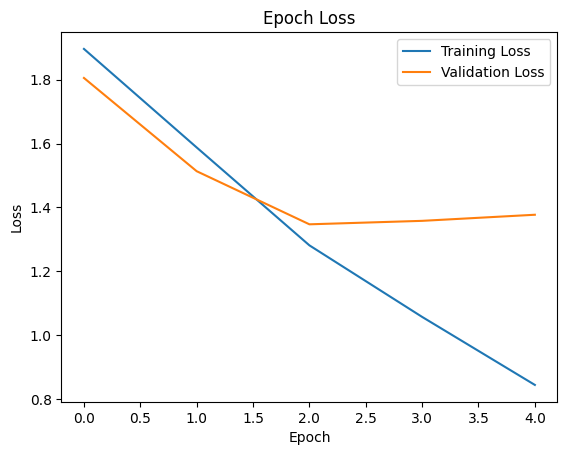

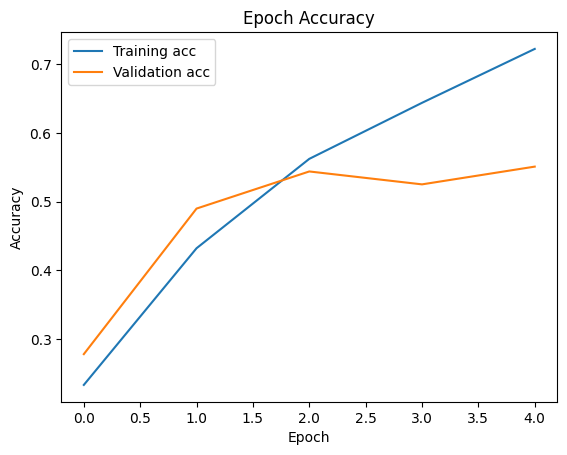

In [15]:
import matplotlib.pyplot as plt

# Plot the epoch loss
plt.plot(train_epoch_losses, label='Training Loss')
plt.plot(valid_epoch_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Epoch Loss')
plt.show()

# Plot the epoch accuracies
plt.plot(train_epoch_acc, label='Training acc')
plt.plot(valid_epoch_acc, label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Epoch Accuracy')
plt.show()

In [16]:
test_data_path = Path(config['data']['root_path'], config['data']['test_data_path'])
test_dataset = RhetoricalRoleDataset(test_data_path, tokenizer,mapper=mapper)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []


# Predict 
for (step, batch) in enumerate(test_loader):
  # Add batch to GPU
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  labels = batch['labels'].to(device)

    
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

  logits = outputs[1]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

loaded data with 835 sentences and 835 compressed labels
    DONE.


In [17]:
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_labels.flatten()

flat_accuracy(predictions,true_labels)

0.6239520958083832

In [18]:
from sklearn.metrics import classification_report
print(classification_report(labels_flat, pred_flat))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       145
           1       0.62      0.57      0.59       115
           2       0.69      0.36      0.47        25
           3       0.69      0.27      0.39        99
           4       0.52      0.75      0.61       191
           5       0.78      0.72      0.75       115
           6       0.68      0.53      0.60       145

    accuracy                           0.62       835
   macro avg       0.66      0.57      0.59       835
weighted avg       0.64      0.62      0.61       835



In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
output_model = '/content/drive/MyDrive/OS/model_bert_sentence_IT.pth'

# save
def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(model, optimizer)

# load
#checkpoint = torch.load(output_model, map_location='cpu')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])